# The notebook connects gets data from Snowflake to train a ML model and deploy it on Snowpark to run batch inference.

@author Mash Syed### Dataset ####
#### https://www.kaggle.com/datasets/neelesh0602/bankcsv


In [143]:
#pip install snowflake-connector-python
#pip install "snowflake-connector-python[pandas]"
#pip install --upgrade snowflake-sqlalchemy
#pip install xgboost==1.5.0
#pip install snowflake-snowpark-python
#pip install "snowflake-snowpark-python[pandas]"

In [144]:
# azure ml packages
from azureml.core import Workspace
from azureml.core import Keyvault

# snowflake packages
from snowflake.snowpark import Session
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import *
from snowflake.snowpark import functions as F

# import standard python libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import snowflake.connector
%matplotlib inline

# Pull in relevant ML libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#Classifier
from sklearn.ensemble import RandomForestClassifier

# use sqlalchemy connector to write to snowflake
from sqlalchemy.dialects import registry
registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

In [145]:
# Reading credentials from secrets
ws = Workspace.from_config()

keyvault = ws.get_default_keyvault()
sfuser = keyvault.get_secret(name="sf-user")
sfpasswd = keyvault.get_secret(name="sf-passwd")
sfaccount = keyvault.get_secret(name="sf-account")
sfhost = keyvault.get_secret(name="sf-host")
sfhostalchemy = keyvault.get_secret(name='sf-host-alchemy')

# Connect To Snowflake and Get Data
#### The Snowflake Python connector is used to connect to Snowflake to fetch the data into a pandas data frame.
#### Reference - https://docs.snowflake.com/en/user-guide/python-connector.html


In [146]:
ctx = snowflake.connector.connect(
    host=sfhost,
    user=sfuser,
    password=sfpasswd,
    account=sfaccount,
    warehouse="compute_wh",
    database="demo",
    schema="source_data"
)

# Create a cursor object.
cur = ctx.cursor()

# Execute a statement that will generate a result set.
sql = "select * from demo.source_data.banking_customers"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()

df.head()

,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,DEPOSIT,CUSTOMERID
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,3
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,4
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,5


# The first thing we should do is convert our target from categorical to a binary value
#### This allows us to group by the target and better understand how the features relate to it.


In [147]:
## map the target variable to 1 or 0
df['DEFAULT_STATUS'] = np.where(df.DEFAULT == 'yes', 1, 0)
## drop the original column
df.drop(columns='DEFAULT', inplace=True)

# Exploratory Data Analysis
#### Exlploratory Data Analysis (EDA) is a process that data scientists apply to investigate, profile, test hypothesis, summarize, and visualize a dataset. In our dataset, we apply the following EDA methods:

- Use summary statistics to describe the dataframe
- Check for class imbalance
- Summarize data based on multiple variables
- Visualize using Bar Charts & Histograms
- Correlation Matrix

# Summary Statistics

In [148]:
df.describe()

,AGE,BALANCE,DURATION,PDAYS,PREVIOUS,CUSTOMERID,DEFAULT_STATUS
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,371.993818,51.330407,0.832557,5581.500000,0.015051
std,11.913369,3225.413326,347.128386,108.758282,2.292007,3222.336187,0.121761
min,18.000000,-6847.000000,2.000000,-1.000000,0.000000,1.000000,0.000000
25%,32.000000,122.000000,138.000000,-1.000000,0.000000,2791.250000,0.000000
50%,39.000000,550.000000,255.000000,-1.000000,0.000000,5581.500000,0.000000
75%,49.000000,1708.000000,496.000000,20.750000,1.000000,8371.750000,0.000000
max,95.000000,81204.000000,3881.000000,854.000000,58.000000,11162.000000,1.000000


# Check Target Variable For Class Imbalance
#### Classes are heavily imbalanced with a default rate of only 1.5%.

In [149]:
df.DEFAULT_STATUS.value_counts()

0    10994
1      168
Name: DEFAULT_STATUS, dtype: int64

In [150]:
print('Default rate is:', str(round((df[df.DEFAULT_STATUS == 1].CUSTOMERID.count() / df.CUSTOMERID.count())*100, 1)) + '%') 

Default rate is: 1.5%


# Summarize Variables by Default Status
#### Below we can see that there is a significant difference in the 'BALANCE', 'PDAYS', AND 'PREVIOUS' columns between customers that default and those that dont.

In [151]:
df.groupby('DEFAULT_STATUS').mean().reset_index()

,DEFAULT_STATUS,AGE,BALANCE,DURATION,PDAYS,PREVIOUS,CUSTOMERID
0,0,41.248772,1552.840640,372.412589,51.818174,0.842550,5569.350737
1,1,40.130952,-61.803571,344.589286,19.410714,0.178571,6376.553571


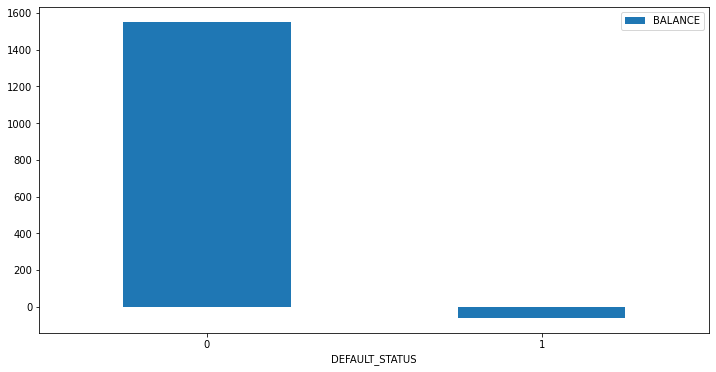

In [152]:
df.groupby('DEFAULT_STATUS').mean().reset_index().plot(kind='bar', x='DEFAULT_STATUS', y='BALANCE', rot=0, figsize=(12,6))

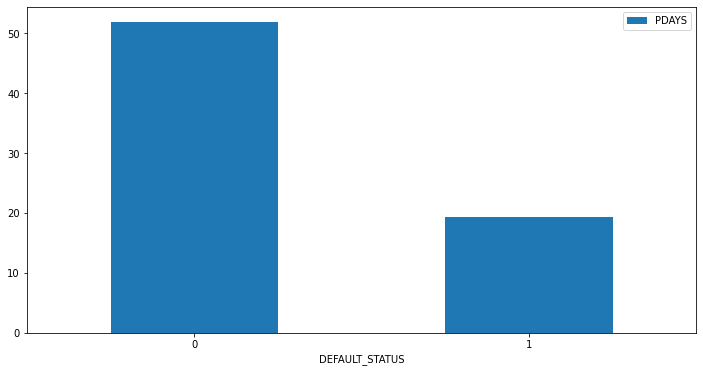

In [153]:
df.groupby('DEFAULT_STATUS').mean().reset_index().plot(kind='bar', x='DEFAULT_STATUS', y='PDAYS', rot=0, figsize=(12,6))

# Aggregate The Data By Education, Default Status
#### Determining a significant different in BALANCE when factoring in EDUCATION.

In [154]:
df[['EDUCATION', 'DEFAULT_STATUS', 'BALANCE']].groupby(['EDUCATION', 'DEFAULT_STATUS']).mean().reset_index() #.rename(columns={'CUSTOMERID':'COUNT'})

,EDUCATION,DEFAULT_STATUS,BALANCE
0,primary,0,1554.713120
1,primary,1,-84.000000
2,secondary,0,1316.348535
3,secondary,1,-10.463415
4,tertiary,0,1871.866246
5,tertiary,1,-126.125000
6,unknown,0,1780.938525
7,unknown,1,-115.000000


# Correlation Matrix
#### Not a strong correlation between any of the numeric features and the target column ('DEFAULT_STATUS').

In [155]:
df.corr()

,AGE,BALANCE,DURATION,PDAYS,PREVIOUS,CUSTOMERID,DEFAULT_STATUS
AGE,1.000000,0.112300,0.000189,0.002774,0.020169,-0.019550,-0.011425
BALANCE,0.112300,1.000000,0.022436,0.017411,0.030805,-0.051580,-0.060954
DURATION,0.000189,0.022436,1.000000,-0.027392,-0.026716,-0.454749,-0.009760
PDAYS,0.002774,0.017411,-0.027392,1.000000,0.507272,-0.072481,-0.036282
PREVIOUS,0.020169,0.030805,-0.026716,0.507272,1.000000,-0.069119,-0.035273
CUSTOMERID,-0.019550,-0.051580,-0.454749,-0.072481,-0.069119,1.000000,0.030502
DEFAULT_STATUS,-0.011425,-0.060954,-0.009760,-0.036282,-0.035273,0.030502,1.000000


# Plot Histogram
#### By plotting overlapping histograms of customer account balances, we can see the distribution of values for the account balance variable for customers that default vs. those that dont. It's clear that customers that dont default have most or all of their values that are greater than 0 while customers that do default show a significant.

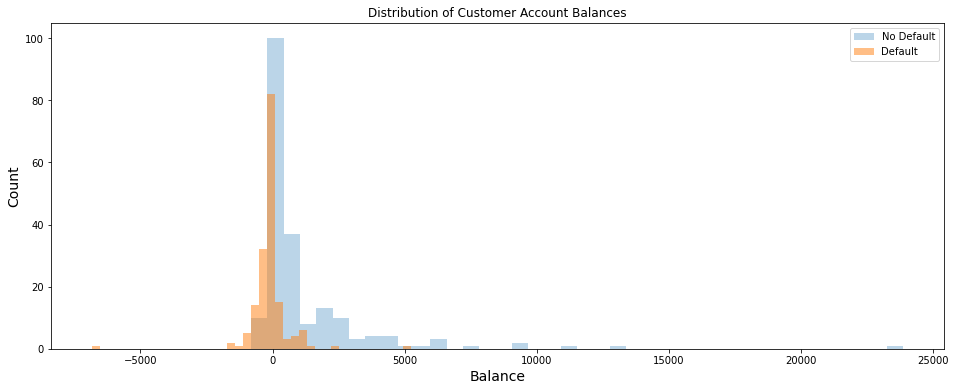

In [156]:
df_hist_1 = df[df.DEFAULT_STATUS == 1].BALANCE
df_hist_0 = df[df.DEFAULT_STATUS == 0].BALANCE.sample(200)
plt.figure(figsize=(16,6))
plt.hist(df_hist_0, bins=40, alpha=0.3, label="No Default")
plt.hist(df_hist_1, bins=40, alpha=0.5, label="Default")
plt.xlabel("Balance", size=14)
plt.ylabel("Count", size=14)
plt.title("Distribution of Customer Account Balances")
plt.legend(loc='upper right')

# Feature Engineering
#### Feature Engineering is the process of transforming your raw data into something more valuable that can help the algorithm predict your outcome. In our dataset, this means two things:
- Turn categorical columns into binary using the get_dummies function in pandas
- Rescale numeric columns using the MinMaxScaler function

In [157]:
## create function to tranform numeric and categorical features
## provide the dataframe and the name of the target column
def create_features(df, target_col_name, id_col_name): 
    # remove the target col before transformation
    df_temp = df.loc[:, ~df.columns.isin([target_col_name, id_col_name])]
    ## For numerics we use min-max rescaling, for categorical we use get_dummies in pandas
    scaler = MinMaxScaler()
    ## Here we chain multiple functions together, we transform both numeric and categorial features and join back the target column
    df_transformed = pd.DataFrame(scaler.fit_transform(df_temp.select_dtypes(include='number')), 
                                        columns=df_temp.select_dtypes(include='number').columns.tolist()).join(pd.get_dummies(df_temp.select_dtypes(include='object'))).join(df[[target_col_name, id_col_name]])
    
    df_transformed.columns = [x.upper() for x in df_transformed.columns]
    return df_transformed

In [158]:
df_transformed = create_features(df, 'DEFAULT_STATUS', 'CUSTOMERID')
df_transformed.head()

,AGE,BALANCE,DURATION,PDAYS,PREVIOUS,JOB_ADMIN.,JOB_BLUE-COLLAR,JOB_ENTREPRENEUR,JOB_HOUSEMAID,JOB_MANAGEMENT,...,CAMPAIGN_8,CAMPAIGN_9,POUTCOME_FAILURE,POUTCOME_OTHER,POUTCOME_SUCCESS,POUTCOME_UNKNOWN,DEPOSIT_NO,DEPOSIT_YES,DEFAULT_STATUS,CUSTOMERID
0,0.532468,0.104371,0.268110,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0.493506,0.078273,0.377675,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,2
2,0.298701,0.092185,0.357566,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,3
3,0.480519,0.105882,0.148750,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,4
4,0.467532,0.079851,0.172983,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,5


# Write features back to Snowflake For Batch Inference
#### We use SQLAlchemy since it doesn't require a pre-defined schema. In our transformed dataframe, we go from 16 columns to 118 columns

#### References: 
- https://docs.snowflake.com/en/user-guide/sqlalchemy.html
- https://stephenallwright.com/python-connector-write-pandas-snowflake/
- https://stephenallwright.com/write-to-snowflake-from-pandas-dataframe/

In [162]:
engine = create_engine(URL(
    account=sfaccount + '.west-us-2.azure',
    user=sfuser,
    password=sfpasswd,
    role='ACCOUNTADMIN',
    warehouse='COMPUTE_WH',
    database='DEMO',      
    schema ='SOURCE_DATA',
    autocommit=True
    ))

tbl_name = 'banking_customers_features'

## drop table if it exists since replace doesnt work in sqlalchemy
# Execute a statement that will generate a result set.
sql = "drop table if exists " + tbl_name
cur.execute(sql)

df_transformed.to_sql(con = engine, 
                    name = tbl_name, 
                    if_exists='replace', #other possible values are 'append' and 'fail',
                    schema='SOURCE_DATA',
                    index=False)

# Split Data Into Train and Test Sets

In [163]:
X = np.array(np.array(df_transformed.loc[:, df_transformed.columns != 'DEFAULT_STATUS']))
y = np.array(df_transformed['DEFAULT_STATUS'])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=42)

# Fit the Transformed Features To a Model

In [164]:
## instantiate a base model with no tuning to hyperparameters
model = RandomForestClassifier(random_state=0, n_jobs=-1)
print(model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [165]:
# train the model on the training data set
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Score The Model Using 5-Fold Cross Validation

In [166]:
## score the model
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.99


# Test the Fitted Model On Unseen Data
#### Now that we have trained our model and run cross validation on our training data, we can apply our model to unseen observations which will allow us to understand how well it performs

In [167]:
y_pred = model.predict(X_test)

# Use the Confusion Matrix To Understand Accuracy
#### Earlier in the notebook, we discussed class imbalance. The confusion matrix shows us how the skew of the default variable impacts our accuracy. There are ways to improve class imbalance but that is outside of the scope of this use case.

In [168]:
## use the confusion matrix to understand accuracy
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)
print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  0
False Positive(FP) =  0
True Negative(TN)  =  1092
False Negative(FN) =  25
Accuracy of the classification = 0.978


# Deploy The Trained Model To Snowpark
#### Open the connection to Snowflake and create a new Snowpark session
#### Reference : https://docs.snowflake.com/en/developer-guide/snowpark/python/index.html



In [170]:
connection_parameters = {
  "account": sfaccount + '.west-us-2.azure',
  "user": sfuser,
  "password": sfpasswd,
  "role": 'ACCOUNTADMIN',
  "warehouse": 'COMPUTE_WH',
  "database": 'DEMO',
  "schema": 'SOURCE_DATA'
}

session = Session.builder.configs(connection_parameters).create()
df = session.create_dataframe([[1, 2], [3, 4]], schema=["a", "b"])
df = df.filter(df.a > 1)
df.show()
pandas_df = df.to_pandas()  # this requires pandas installed in the Python environment
result = df.collect()

-------------
|"A"  |"B"  |
-------------
|3    |4    |
-------------



# Create a Stage To Store the UDF and libraries required for deployment 

In [171]:
#Let's first create a stage to store the artifacts
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


In [172]:
session.add_packages("pandas", "numpy", "scikit-learn==1.0.2")

# Register your trained model as a UDF in your instance of Snowflake

In [173]:
features = df_transformed.columns[:-2].tolist()
predict_churn_model = session.udf.register(lambda *args: 
                                    model.predict(pd.DataFrame(args, columns=features)),
                                    name="predict_churn_model",
                                    stage_location="@MODELSTAGE",
                                    return_type=FloatType(),
                                    is_permanent=True,
                                    replace=True,
                                    input_types=[ArrayType()])

In [174]:
@udf(name='predict_default',is_permanent = True, stage_location = '@MODELSTAGE', replace=True, session=session)
def predict_default(args: list) -> float:
    row = pd.DataFrame([args], columns=features)
    return model.predict(row)

# Apply the deployed model on a random set of customer ID's
#### Test the deployed model (batch inference) out on a random sample of records and write the results to a new table. In this case, we use the feature table (as input) we created in a previous step.

In [175]:
default_prediction_df = session.table('BANKING_CUSTOMERS_FEATURES').sample(n = 400)
default_prediction_df.select(default_prediction_df.CUSTOMERID, default_prediction_df.DEFAULT_STATUS, \
              F.call_udf("predict_default", F.array_construct(*features)).alias('PREDICTED_DEFAULT')) \
        .write.mode('overwrite').saveAsTable('default_detection')

# Final Table with Predicted Values
#### Connect to the new table with predictions and show in a pandas dataframe.

In [176]:
# Execute a statement that will generate a result set.
sql = "select * from demo.source_data.default_detection"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()

df.head()

,CUSTOMERID,DEFAULT_STATUS,PREDICTED_DEFAULT
0,3167,0,0.0
1,10634,0,0.0
2,6504,0,0.0
3,9544,0,0.0
4,9566,0,0.0
